In [1]:
# %% [step1-setup]
# WHY: Reproducible, idempotent setup and paths for the linear models notebook.
from __future__ import annotations

from pathlib import Path
import sys
import json
import logging
import warnings
import re  # Pattern matching to discover SPX-like columns.

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt  # Temp plotting in later exploration.
from matplotlib.patches import Patch  # Legend patches.

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")
logger = logging.getLogger("lin-offline")

def find_project_root(start: Path) -> Path:
    start = start.resolve()
    for p in [start, *start.parents]:
        if (p/"config").exists() and (p/"src").exists():
            return p
    raise AssertionError("Project folders missing: expected 'config' and 'src' somewhere above the notebook.")

ROOT = find_project_root(Path.cwd())
ART_DIR: Path = ROOT / "artifacts"
DATA_DIR: Path = ART_DIR / "data"
MODEL_DIR: Path = ART_DIR / "models"
METRIC_DIR: Path = ART_DIR / "metrics"
FORECAST_DIR: Path = ART_DIR / "forecasts"
for d in (MODEL_DIR, METRIC_DIR, FORECAST_DIR):
    d.mkdir(parents=True, exist_ok=True)

if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

# ---------- USER_TODO: Zentrale Schalter für Testruns ----------
TRAIN_END: str = "2019-12-31"         # Training bis inkl. 2019-12 (pre-COVID regime).
TEST_START: str = "2020-01-31"        # Test ab 2020-01 (OOS pandemic/after).
PROB_THRESHOLDS: list[float] = [0.50, 0.60, 0.70, 0.80, 0.90]  # WHY: "Safety grades" for decision policy.
NEUTRAL_BAND_PCT: float = 0.20        # WHY: ±0.10%: small return forecasts → HOLD to avoid churn.
TRADE_MODE: str = "long_short"         # WHY: "long_flat" (BUY=long, else flat) | "long_short" (symmetric).
USE_RETURN_MODEL: str = "ols"       # WHY: "ridge" | "ols" for sizing/expected return overlay.
PERSIST_ENRICHED: bool = True         # WHY: Persist enriched features with SPX lag for later reuse.

# sklearn smoke test.
try:
    import joblib
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression
    from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
    from sklearn.calibration import CalibratedClassifierCV
    from sklearn.metrics import (
        mean_squared_error, mean_absolute_error, r2_score,
        accuracy_score, f1_score, roc_auc_score,
        precision_score, recall_score,
    )
except Exception as e:
    raise ImportError("Bitte scikit-learn + joblib installieren.") from e

In [2]:
# Load and validate: Load features.

FEATURES_CSV: Path = DATA_DIR / "features_monthly.csv"
FEATURES_PARQ: Path = DATA_DIR / "features_monthly.parquet"
RAW_PATH: Path = DATA_DIR / "raw_data.parquet"

def _read_features(path_csv: Path, path_parquet: Path | None = None) -> pd.DataFrame:
    """Read feature table (CSV preferred), infer date index, and validate targets.
    Args:
        path_csv: CSV path (preferred).
        path_parquet: Optional Parquet path (fallback).
    Returns: DataFrame with DatetimeIndex including targets y_return_next_pct and y_direction_next.
    Raises:
        FileNotFoundError: If neither source exists.
        TypeError: If index cannot be coerced to DatetimeIndex.
        KeyError: If required target columns are missing."""
    if path_csv.exists():
        df = pd.read_csv(path_csv)
        date_col: str | None = None
        # Try to auto-detect a date-like column among the first few columns.
        for c in df.columns[:3]:
            try:
                parsed = pd.to_datetime(df[c], errors="coerce")
                if parsed.notna().mean() > 0.9:
                    date_col = c
                    break
            except Exception:
                pass
        if date_col:
            df[date_col] = pd.to_datetime(df[date_col])
            df = df.set_index(date_col)
        df = df.sort_index()
    elif path_parquet and path_parquet.exists():
        df = pd.read_parquet(path_parquet).sort_index()
    else:
        raise FileNotFoundError(f"Features not found: {path_csv} (or {path_parquet})")

    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("Features index must be a DatetimeIndex.")
    req = {"y_return_next_pct", "y_direction_next"}
    miss = req - set(df.columns)
    if miss:
        raise KeyError(f"Missing target column(s) in features: {sorted(miss)}")
    return df

def _read_raw_monthly(path: Path) -> pd.DataFrame:
    """Read merged monthly raw data (Parquet) and normalize index."""
    if not path.exists():
        raise FileNotFoundError(f"raw_data.parquet not found at {path}")
    df = pd.read_parquet(path)
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    return df.sort_index()

def _find_spx_col(cols: list[str]) -> str | None:
    """Heuristically find an S&P-500 price/level column by common names/patterns."""
    if "SP500" in cols:
        return "SP500"
    pats = [
        r"(?:\^?gspc|spy|spx|s&p).*adj.?close",
        r"(?:\^?gspc|spy|spx|s&p).*(?:close|price|level)",
        r"(?:sp500|spx)$",
    ]
    for pat in pats:
        rx = re.compile(pat, re.IGNORECASE)
        matches = [c for c in cols if rx.search(str(c))]
        if matches:
            return matches[0]
    return None

def _coerce_float(s: pd.Series) -> pd.Series:
    """Coerce numeric series to float64 to avoid integer rounding artifacts."""
    return pd.to_numeric(s, errors="coerce").astype("float64")

def _ret_pct_from_price(px: pd.Series) -> pd.Series:
    """Current month return r_t = (P_t / P_{t-1} - 1) * 100, aligned at t."""
    r = px.pct_change() * 100.0
    r.name = "spx_return_t_pct"
    return r

def _next_ret_pct_from_price(px: pd.Series) -> pd.Series:
    """Next month return r_{t+1} in %, aligned at index t (for benchmarking only)."""
    r_next = px.pct_change().shift(-1) * 100.0
    r_next.name = "spx_return_next_pct"
    return r_next

# Load feature/target table and raw monthly inputs.
DF: pd.DataFrame = _read_features(FEATURES_CSV, FEATURES_PARQ)
raw_df: pd.DataFrame = _read_raw_monthly(RAW_PATH)

# Derive SPX returns from a discovered price/level column.
spx_col = _find_spx_col(list(raw_df.columns))
if spx_col is None:
    raise RuntimeError("Keine S&P-Preis-/Levelsäule in raw_data.parquet gefunden (erwartet z.B. 'SP500').")
spx_px = _coerce_float(raw_df[spx_col])

spx_ret_t_pct = _ret_pct_from_price(spx_px)           # r_t     (known at t)
spx_ret_lag1_pct = spx_ret_t_pct.shift(1)             # r_{t-1} (safe feature)
SPX_NEXT_PCT = _next_ret_pct_from_price(spx_px)       # r_{t+1} (benchmark only)

# Align to feature index and *only* add safe lag feature.
spx_ret_t_pct = spx_ret_t_pct.reindex(DF.index)
spx_ret_lag1_pct = spx_ret_lag1_pct.reindex(DF.index)
SPX_NEXT_PCT = SPX_NEXT_PCT.reindex(DF.index)
DF["spx_return_lag1_pct"] = spx_ret_lag1_pct 

print(
    f"[SPX] source='{spx_col}', added feature='spx_return_lag1_pct'; "
    f"benchmark next-return kept OUT of DF (len={SPX_NEXT_PCT.notna().sum()})."
)
print("Features shape:", DF.shape, str(DF.index.min())[:10], "→", str(DF.index.max())[:10])

# Optional: persist enriched features (without any '*next*' leakage).
if PERSIST_ENRICHED:
    (DATA_DIR / "features_monthly_enriched.csv").write_text(DF.to_csv(index=True), encoding="utf-8")
    try:
        DF.to_parquet(DATA_DIR / "features_monthly_enriched.parquet")
    except Exception:
        pass  # Parquet persistence is best-effort in the notebook context.

# Prepare benchmark series (decimal form) for later performance comparison.
spx_next_dec = (SPX_NEXT_PCT / 100.0).rename("sp500_bh")

[SPX] source='SP500', added feature='spx_return_lag1_pct'; benchmark next-return kept OUT of DF (len=196).
Features shape: (196, 17) 2009-02-28 → 2025-05-31


In [3]:
# Split and xy fix
try:
    from src.utils.splits import time_split, split_Xy
except Exception:
    def time_split(df: pd.DataFrame, train_end: str, test_start: str, test_end: str | None = None):
        """Minimal local fallback: temporal split by inclusive bounds."""
        train = df.loc[:train_end].copy()
        test = df.loc[test_start:(test_end or df.index.max())].copy()
        return train, test
    def split_Xy(df: pd.DataFrame, y_reg: str = "y_return_next_pct", y_clf: str = "y_direction_next"):
        """Minimal local fallback: X and y splits with classification dtype."""
        X = df.drop(columns=[y_reg, y_clf])
        yr = df[y_reg]
        yc = df[y_clf].astype("int8")
        return X, yr, yc

train_df, test_df = time_split(DF, train_end=TRAIN_END, test_start=TEST_START, test_end=None)

def _safe_split_Xy(df: pd.DataFrame, y_reg: str, y_clf: str):
    """Split features/targets and drop any column with 'next' in its name (except targets)."""
    leak_cols = [c for c in df.columns if ("next" in str(c).lower()) and (c not in {y_reg, y_clf})]
    if leak_cols:
        print("[LEAK-GUARD] dropping from X:", leak_cols)
    X = df.drop(columns=[y_reg, y_clf] + leak_cols)
    yr = df[y_reg]
    yc = df[y_clf].astype("int8")
    return X, yr, yc

Xtr, ytr_reg, ytr_clf = _safe_split_Xy(train_df, "y_return_next_pct", "y_direction_next")
Xte, yte_reg, yte_clf = _safe_split_Xy(test_df,  "y_return_next_pct", "y_direction_next")

def _assert_no_nan(X: pd.DataFrame, y: pd.Series, ctx: str) -> None:
    """Fail early if NaNs are present; feature notebook should handle imputation upstream."""
    if X.isna().any().any() or y.isna().any():
        raise ValueError(f"NaNs found in {ctx}. Bitte im Feature-Step bereinigen.")

_assert_no_nan(Xtr, ytr_reg, "train-regression")
_assert_no_nan(Xte, yte_reg, "test-regression")
_assert_no_nan(Xtr, ytr_clf, "train-classification")
_assert_no_nan(Xte, yte_clf, "test-classification")

print("Train:", train_df.index.min().date(), "→", train_df.index.max().date(), "| n=", len(train_df))
print("Test :", test_df.index.min().date(),  "→", test_df.index.max().date(),  "| n=", len(test_df))

Train: 2009-02-28 → 2019-12-31 | n= 131
Test : 2020-01-31 → 2025-05-31 | n= 65


In [4]:
# Train regression:
def _make_tscv(n_splits: int = 5, test_size: int = 12, gap: int = 1, max_train_size: int | None = None):
    """Build a TimeSeriesSplit with explicit test_size and gap where supported."""
    try:
        return TimeSeriesSplit(
            n_splits=n_splits,
            test_size=test_size,
            gap=gap,
            max_train_size=max_train_size,
        )
    except TypeError:
        logger.warning(
            "TimeSeriesSplit(test_size/gap) unsupported in your scikit-learn version. "
            "Falling back to TimeSeriesSplit(n_splits=%d) without gap/explicit test_size. "
            "Consider upgrading sklearn (>=1.1) for proper embargo handling.",
            n_splits,
        )
        return TimeSeriesSplit(n_splits=n_splits, max_train_size=max_train_size)

tscv = _make_tscv(n_splits=5, test_size=12, gap=1, max_train_size=None)

ols = Pipeline([("scaler", StandardScaler()), ("est", LinearRegression())])  # Baseline linear model.
ridge = Pipeline([("scaler", StandardScaler()), ("est", Ridge())])           # L2 regularization mitigates multicollinearity.

grid_ridge = GridSearchCV(
    ridge,
    param_grid={"est__alpha": [0.1, 0.5, 1, 2, 5, 10]},  # Small, sensible search to reduce overfitting risk with few samples.
    scoring="neg_root_mean_squared_error",               # Directly optimizes RMSE.
    cv=tscv, n_jobs=-1, refit=True, error_score="raise"  # Anchored forward CV.
)

ols.fit(Xtr, ytr_reg)
grid_ridge.fit(Xtr, ytr_reg)

pred_ols   = pd.Series(ols.predict(Xte),   index=Xte.index, name="ols")  # Preserve index alignment for safe metric calc.
pred_ridge = pd.Series(grid_ridge.predict(Xte), index=Xte.index, name="ridge")

def _rmse(a: pd.Series, b: pd.Series) -> float:
    """Root mean squared error as scalar float (JSON-friendly)."""
    return float(np.sqrt(mean_squared_error(a, b)))

ridge_rmse = _rmse(yte_reg, pred_ridge); ridge_mae = float(mean_absolute_error(yte_reg, pred_ridge)); ridge_r2 = float(r2_score(yte_reg, pred_ridge))
ols_rmse   = _rmse(yte_reg, pred_ols);   ols_mae   = float(mean_absolute_error(yte_reg, pred_ols));   ols_r2   = float(r2_score(yte_reg, pred_ols))

BEST_REG_NAME = "ridge" if ridge_rmse <= ols_rmse else "ols"  # Pick lower RMSE to define the reference return model.
pred_best = pred_ridge if BEST_REG_NAME == "ridge" else pred_ols

logger.info("RIDGE: rmse=%.4f mae=%.4f r2=%.4f alpha=%s", ridge_rmse, ridge_mae, ridge_r2, grid_ridge.best_params_["est__alpha"])
logger.info("OLS  : rmse=%.4f mae=%.4f r2=%.4f", ols_rmse, ols_mae, ols_r2)
logger.info("Best regression = %s", BEST_REG_NAME.upper())

INFO: RIDGE: rmse=5.0347 mae=4.2217 r2=0.0424 alpha=10
INFO: OLS  : rmse=5.1870 mae=4.3686 r2=-0.0164
INFO: Best regression = RIDGE


In [5]:
# Train classification and safety grades
tscv = _make_tscv(n_splits=5, test_size=12, gap=1, max_train_size=None)

logit = Pipeline([
    ("scaler", StandardScaler()),  # Stabilize optimization with standardized features.
    ("est", LogisticRegression(penalty="l2", solver="liblinear", random_state=42))  # Robust on small N. L2 regularization.
])

# Tune C on ROC AUC.
grid_logit = GridSearchCV(
    logit,
    param_grid={"est__C": [0.1, 0.5, 1, 2, 5, 10]},
    scoring="roc_auc",
    cv=tscv,
    n_jobs=-1,
    refit=True,
    error_score="raise",
)
grid_logit.fit(Xtr, ytr_clf.astype("int8"))

def _calibrator(estimator, method: str, cv):
    """Create CalibratedClassifierCV compatible with both old/new sklearn."""
    try:
        return CalibratedClassifierCV(estimator=estimator, method=method, cv=cv)
    except TypeError:
        logger.warning("CalibratedClassifierCV: falling back to 'base_estimator' (older sklearn).")
        return CalibratedClassifierCV(base_estimator=estimator, method=method, cv=cv)

# Isotonic calibration (monotonic) reduces miscalibration.
cal = _calibrator(grid_logit.best_estimator_, method="isotonic", cv=tscv)
cal.fit(Xtr, ytr_clf.astype("int8"))

proba: pd.Series = pd.Series(cal.predict_proba(Xte)[:, 1], index=Xte.index, name="p_up")
predC: pd.Series = (proba >= 0.5).astype("int8")

clf_acc = float(accuracy_score(yte_clf, predC))
clf_f1  = float(f1_score(yte_clf, predC, zero_division=0))  #  Avoid warnings if one class is never predicted.
clf_auc = float(roc_auc_score(yte_clf, proba))
logger.info("LOGIT (calibrated): acc=%.4f f1=%.4f auc=%.4f", clf_acc, clf_f1, clf_auc)

def decide_action(p_up: float, ret_pred_pct: float, thr: float, band: float) -> str:
    """BUY if p(up)≥thr and |return|≥band; SELL if p(down)≥thr and |return|≥band; else HOLD.

    # WHY:
    # - `band` filters tiny signals to reduce churn.
    # - `thr` encodes confidence; choose via CV on the train set (not on the test set).
    """
    if abs(ret_pred_pct) < band:
        return "HOLD"
    if p_up >= thr:
        return "BUY"
    if (1.0 - p_up) >= thr:
        return "SELL"
    return "HOLD"

# Decision table for the latest test point (illustrative only; do not tune on test).
ret_model = pred_ridge if USE_RETURN_MODEL == "ridge" else pred_ols
t = Xte.index[-1]
p_t = float(proba.loc[t]); r_t = float(ret_model.loc[t])

rows = [
    {"threshold": thr,
     "action": decide_action(p_t, r_t, thr, NEUTRAL_BAND_PCT),
     "p_up": round(p_t, 4), "ret_pred_pct": round(r_t, 3)}
    for thr in PROB_THRESHOLDS
]
print(f"Next Month Decision (t={str(t.date())}):")
print(pd.DataFrame(rows).to_string(index=False))

INFO: LOGIT (calibrated): acc=0.6154 f1=0.7423 auc=0.4873


Next Month Decision (t=2025-05-31):
 threshold action   p_up  ret_pred_pct
       0.5    BUY 0.6143        -0.449
       0.6    BUY 0.6143        -0.449
       0.7   HOLD 0.6143        -0.449
       0.8   HOLD 0.6143        -0.449
       0.9   HOLD 0.6143        -0.449


In [6]:
# Build strategies and summary: Unified policy (p_up + return band) over the entire test window. Compare against Buy&Hold and SPX.

def _perf(r: pd.Series) -> tuple[float, float, float]:
    """Compute (CAGR, Sharpe, Max Drawdown) for monthly decimal returns.
    Returns: (cagr, sharpe, max_drawdown)"""
    r = r.fillna(0.0)
    curve = (1 + r).cumprod()
    n = r.shape[0]
    cagr = float(curve.iloc[-1] ** (12 / max(n, 1)) - 1)
    vol = float(r.std(ddof=0) * np.sqrt(12))
    sharpe = float(cagr / vol) if vol > 0 else float("nan")
    dd = (curve / curve.cummax()) - 1.0
    return cagr, sharpe, float(dd.min())

def decide_signal(p_up: float, ret_pred_pct: float, thr: float, band: float, mode: str) -> int:
    """Generate trading signal: +1 BUY, 0 HOLD, −1 SELL (short allowed only in 'long_short')."""
    if abs(ret_pred_pct) < band:
        return 0
    if p_up >= thr:
        return 1
    if (1.0 - p_up) >= thr:
        return -1 if mode == "long_short" else 0
    return 0

# Inputs
test_idx = Xte.index
asset_next_dec = (yte_reg / 100.0).rename("asset_bh")  # Asset buy&hold benchmark in decimals.

spx_next_dec_test: pd.Series | None = None
if "spx_next_dec" in globals():
    spx_next_dec_test = spx_next_dec.reindex(test_idx)

# Consistent signals & returns across thresholds.
results_by_thr: dict[float, dict[str, pd.Series]] = {}
perf_rows: list[dict[str, float]] = []
ret_model = pred_ridge if USE_RETURN_MODEL == "ridge" else pred_ols

for thr in PROB_THRESHOLDS:
    sig = pd.Series(
        [
            decide_signal(float(proba.loc[t]), float(ret_model.loc[t]), thr, NEUTRAL_BAND_PCT, TRADE_MODE)
            for t in test_idx
        ],
        index=test_idx,
        name=f"signal@{thr:.2f}",
    )
    if TRADE_MODE == "long_short":
        strat_ret = (asset_next_dec * sig).rename(f"strategy@{thr:.2f}")
    else:
        strat_ret = (asset_next_dec * (sig == 1).astype(int)).rename(f"strategy@{thr:.2f}")

    results_by_thr[thr] = {"signal": sig, "ret": strat_ret}
    c, s, d = _perf(strat_ret)
    perf_rows.append({"threshold": thr, "STRAT_CAGR": c, "STRAT_SHARPE": s, "STRAT_MAX_DD": d})

# Aggregate performance vs. Buy&Hold and SPX.
perf_df = pd.DataFrame(perf_rows).set_index("threshold").sort_index()
c_bh, s_bh, d_bh = _perf(asset_next_dec)
perf_df["BH_CAGR"], perf_df["BH_SHARPE"], perf_df["BH_MAX_DD"] = c_bh, s_bh, d_bh
if spx_next_dec_test is not None and spx_next_dec_test.notna().any():
    c_spx, s_spx, d_spx = _perf(spx_next_dec_test)
    perf_df["SPX_CAGR"], perf_df["SPX_SHARPE"], perf_df["SPX_MAX_DD"] = c_spx, s_spx, d_spx

print(perf_df.round(4))

# Persist forecasts (test window) for reproducibility/comparison.
pd.DataFrame(
    {"y_true_pct": yte_reg, "ols": pred_ols, "ridge": pred_ridge},
    index=test_idx,
).to_csv(FORECAST_DIR / "linear_reg.csv")

pd.DataFrame(
    {"y_true_dir": yte_clf, "p_up": proba, "pred@0.5": (proba >= 0.5).astype(int)},
    index=test_idx,
).to_csv(FORECAST_DIR / "linear_clf.csv")

# Persist metrics bundle (single-run snapshot).
metrics_bundle = {
    "RIDGE": {
        "rmse": float(np.sqrt(mean_squared_error(yte_reg, pred_ridge))),
        "mae": float(mean_absolute_error(yte_reg, pred_ridge)),
        "r2": float(r2_score(yte_reg, pred_ridge)),
        "alpha": float(grid_ridge.best_params_["est__alpha"]),
    },
    "OLS": {
        "rmse": float(np.sqrt(mean_squared_error(yte_reg, pred_ols))),
        "mae": float(mean_absolute_error(yte_reg, pred_ols)),
        "r2": float(r2_score(yte_reg, pred_ols)),
    },
    "LOGIT": {
        "acc": float(accuracy_score(yte_clf, (proba >= 0.5).astype(int))),
        "f1": float(f1_score(yte_clf, (proba >= 0.5).astype(int), zero_division=0)),
        "auc": float(roc_auc_score(yte_clf, proba)),
    },
    "PERF_BY_THRESHOLD": perf_df.round(6).to_dict(orient="index"),
}
(METRIC_DIR / "linear_models.json").write_text(json.dumps(metrics_bundle, indent=2), encoding="utf-8")
print("Saved:", METRIC_DIR / "linear_models.json")

           STRAT_CAGR  STRAT_SHARPE  STRAT_MAX_DD  BH_CAGR  BH_SHARPE  \
threshold                                                               
0.5            0.1199        0.6999       -0.2877   0.1273     0.7143   
0.6            0.0346        0.2433       -0.2260   0.1273     0.7143   
0.7            0.0204        0.1664       -0.2235   0.1273     0.7143   
0.8            0.0504        0.6445       -0.0934   0.1273     0.7143   
0.9            0.0221        0.3187       -0.0934   0.1273     0.7143   

           BH_MAX_DD  SPX_CAGR  SPX_SHARPE  SPX_MAX_DD  
threshold                                               
0.5          -0.2477    0.1273      0.7143     -0.2477  
0.6          -0.2477    0.1273      0.7143     -0.2477  
0.7          -0.2477    0.1273      0.7143     -0.2477  
0.8          -0.2477    0.1273      0.7143     -0.2477  
0.9          -0.2477    0.1273      0.7143     -0.2477  
Saved: C:\Users\gamer\Desktop\AktienPrognose\artifacts\metrics\linear_models.json


           STRAT_CAGR  STRAT_SHARPE  STRAT_MAX_DD  BH_CAGR  BH_SHARPE  \
threshold                                                               
0.5            0.1215        0.6948       -0.2877   0.1273     0.7143   
0.6            0.1201        0.6861       -0.2747   0.1273     0.7143   
0.7            0.1457        0.8403       -0.2477   0.1273     0.7143   
0.8            0.1356        0.8738       -0.2477   0.1273     0.7143   
0.9            0.0945        0.7993       -0.1319   0.1273     0.7143   

           BH_MAX_DD  SPX_CAGR  SPX_SHARPE  SPX_MAX_DD  
threshold                                               
0.5          -0.2477    0.1273      0.7143     -0.2477  
0.6          -0.2477    0.1273      0.7143     -0.2477  
0.7          -0.2477    0.1273      0.7143     -0.2477  
0.8          -0.2477    0.1273      0.7143     -0.2477  
0.9          -0.2477    0.1273      0.7143     -0.2477  

Decision/precision summary:
     trade_rate  acc_all  precision_all  recall_all  f1_all 

<Figure size 640x480 with 0 Axes>

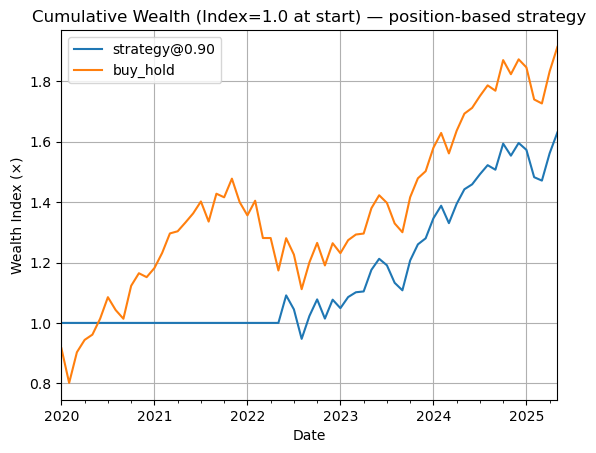

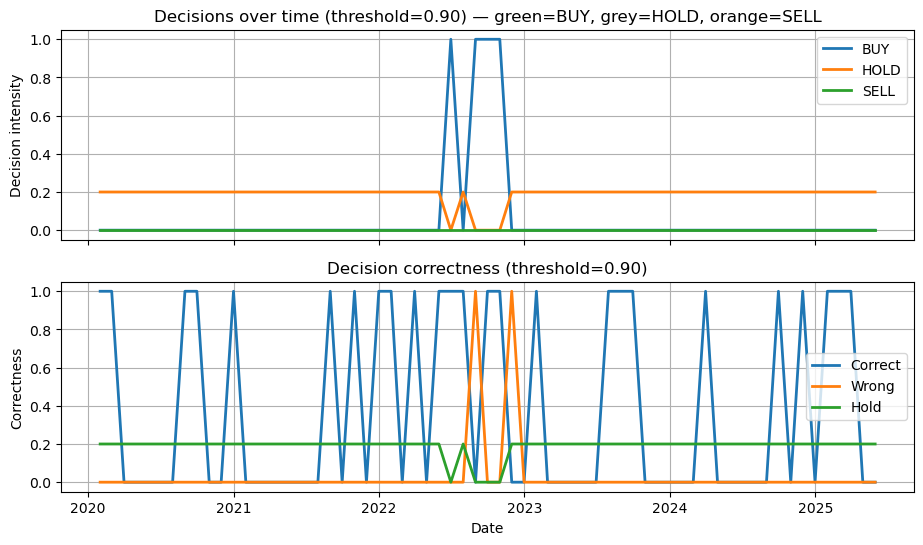

In [7]:
# notebook: 20_train_eval_linear.ipynb
# %% [step6-build-strategies-and-summary]  # REPLACE
# WHY: Make strategy returns consistent with an investor who *stays invested* after a BUY
#      until a SELL occurs. Previously, we multiplied returns by (signal == BUY) only for
#      that *month*, which undercounts PnL on HOLD months and explains the mismatch with
#      the DCA simulation. We now derive a persistent *position* series from signals.

from dataclasses import dataclass

# ---- controls (reuse globals) ----
REQUIRE_NEG_RET_FOR_SELL: bool = True  # WHY: If True, SELL only when predicted return is negative AND p(down) >= thr.

def _perf(r: pd.Series) -> tuple[float, float, float]:
    """Compute (CAGR, Sharpe, Max Drawdown) for monthly decimal returns."""
    r = r.fillna(0.0)
    curve = (1 + r).cumprod()
    n = r.shape[0]
    cagr = float(curve.iloc[-1] ** (12 / max(n, 1)) - 1)
    vol = float(r.std(ddof=0) * np.sqrt(12))
    sharpe = float(cagr / vol) if vol > 0 else float("nan")
    dd = (curve / curve.cummax()) - 1.0
    return cagr, sharpe, float(dd.min())

def decide_signal(p_up: float, ret_pred_pct: float, thr: float, band: float, mode: str) -> int:
    """Monthly *decision* signal: +1 BUY, 0 HOLD, -1 SELL (SELL active only in long_short)."""
    if abs(ret_pred_pct) < band:
        return 0
    if p_up >= thr:
        return 1
    # SELL if sufficiently confident *down*; optional guard on negative return forecast:
    if (1.0 - p_up) >= thr and (not REQUIRE_NEG_RET_FOR_SELL or (ret_pred_pct < 0)):
        return -1 if mode == "long_short" else 0  # WHY: In long_flat, SELL means 'go to cash' (0).
    return 0

def signals_to_position(sig: pd.Series, mode: str = "long_flat") -> pd.Series:
    """Convert one-month *signals* into a persistent *position* {-1,0,1}.
    - long_flat: {-1} is treated as 0 (flat). BUY sets position=1; SELL sets to 0.
    - long_short: BUY→+1, SELL→-1; HOLD keeps last position.
    """
    s = sig.astype(int).copy()
    if mode == "long_flat":
        s = s.replace(-1, 0)
    # map to {+1, 0, -1} with HOLD as NaN so that we can forward-fill last decision
    m = s.replace({0: np.nan})
    pos = m.ffill().fillna(0).astype(int)
    if mode == "long_flat":
        pos = pos.clip(lower=0, upper=1)
    return pos

# ---- build strategy for each threshold using *positions* ----
test_idx = Xte.index
asset_next_dec = (yte_reg / 100.0).rename("asset_bh")  # decimal monthly returns of the target

results_by_thr = {}  # rebuild to keep consistent semantics
perf_rows = []
ret_model = pred_ridge if USE_RETURN_MODEL == "ridge" else pred_ols

for thr in PROB_THRESHOLDS:
    # monthly decisions based on probabilities + return band
    sig = pd.Series(
        [decide_signal(float(proba.loc[t]), float(ret_model.loc[t]), thr, NEUTRAL_BAND_PCT, TRADE_MODE)
         for t in test_idx],
        index=test_idx, name=f"signal@{thr:.2f}"
    )

    # persistent positions derived from signals
    pos = signals_to_position(sig, mode=TRADE_MODE).rename(f"position@{thr:.2f}")

    # RETURNS:
    # - buy&hold of the asset: asset_next_dec
    # - strategy: multiply monthly returns by the *position* (not just 'BUY this month')
    if TRADE_MODE == "long_short":
        strat_ret = (asset_next_dec * pos).rename(f"strategy@{thr:.2f}")
    else:
        strat_ret = (asset_next_dec * (pos == 1).astype(int)).rename(f"strategy@{thr:.2f}")

    # store artifacts for plotting and DCA step
    results_by_thr[thr] = {"signal": sig, "position": pos, "ret": strat_ret}

    # headline performance
    c, s, d = _perf(strat_ret)
    perf_rows.append({"threshold": thr, "STRAT_CAGR": c, "STRAT_SHARPE": s, "STRAT_MAX_DD": d})

# Buy&Hold / SPX
perf_df = pd.DataFrame(perf_rows).set_index("threshold").sort_index()
c_bh, s_bh, d_bh = _perf(asset_next_dec)
perf_df["BH_CAGR"], perf_df["BH_SHARPE"], perf_df["BH_MAX_DD"] = c_bh, s_bh, d_bh
if "spx_next_dec" in globals():
    spx_next_dec_test = spx_next_dec.reindex(test_idx)
    if spx_next_dec_test.notna().any():
        c_spx, s_spx, d_spx = _perf(spx_next_dec_test)
        perf_df["SPX_CAGR"], perf_df["SPX_SHARPE"], perf_df["SPX_MAX_DD"] = c_spx, s_spx, d_spx

print(perf_df.round(4))

# ---- classification-style summary per threshold (uses *signals*) ----
def _summ_class_stats(thr: float, sig: pd.Series) -> dict[str, float]:
    """Compute trade rate & precision metrics for long_flat (BUY=positive class)."""
    is_trade = (sig == 1) if TRADE_MODE == "long_flat" else (sig != 0)
    trade_rate = float(is_trade.mean())
    y_pred = (proba >= thr).astype(int)  # aligns with 'BUY when p_up >= thr'
    acc = float(accuracy_score(yte_clf, y_pred))
    prec = float(precision_score(yte_clf, y_pred, zero_division=0))
    rec = float(recall_score(yte_clf, y_pred, zero_division=0))
    f1v = float(f1_score(yte_clf, y_pred, zero_division=0))
    # precision on actual trades only (BUYs)
    mask = y_pred == 1
    prec_on_trades = float(precision_score(yte_clf[mask], y_pred[mask], zero_division=0)) if mask.any() else float("nan")
    return {
        "trade_rate": round(trade_rate, 4),
        "acc_all": round(acc, 4),
        "precision_all": round(prec, 4),
        "recall_all": round(rec, 4),
        "f1_all": round(f1v, 4),
        "precision_on_trades": round(prec_on_trades, 4),
        "n_BUY": int((sig == 1).sum()),
        "n_HOLD": int((sig == 0).sum()),
        "n_SELL": int((sig == -1).sum()),
    }

summ = pd.DataFrame({thr: _summ_class_stats(thr, results_by_thr[thr]["signal"]) for thr in PROB_THRESHOLDS}).T
print("\nDecision/precision summary:")
print(summ.to_string())

# ---- plots: cumulative wealth using *positions* ----
PLOT_THRESHOLD = 0.90  # user control
pos_strategy_curve = (1 + results_by_thr[PLOT_THRESHOLD]["ret"]).cumprod().rename(f"strategy@{PLOT_THRESHOLD:.2f}")
bh_curve = (1 + asset_next_dec).cumprod().rename("buy_hold")
curves = pd.concat([pos_strategy_curve, bh_curve], axis=1)

plt.figure()
curves.plot()
plt.title("Cumulative Wealth (Index=1.0 at start) — position-based strategy")
plt.xlabel("Date"); plt.ylabel("Wealth Index (×)")
plt.grid(True); plt.legend(); plt.show()

# ---- plots: decision timeline (BUY/HOLD/SELL counts match 'summ') ----
sig_plot = results_by_thr[PLOT_THRESHOLD]["signal"]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6), sharex=True)

ax1.plot(sig_plot.index, (sig_plot == 1).astype(int), label="BUY", linewidth=2)
ax1.plot(sig_plot.index, (sig_plot == 0).astype(int) * 0.2, label="HOLD", linewidth=2)
ax1.plot(sig_plot.index, (sig_plot == -1).astype(int), label="SELL", linewidth=2)
ax1.set_title(f"Decisions over time (threshold={PLOT_THRESHOLD:.2f}) — green=BUY, grey=HOLD, orange=SELL")
ax1.set_ylabel("Decision intensity"); ax1.grid(True)
ax1.legend()

# correctness plot
correct = ((yte_reg > 0).astype(int) == (proba >= PLOT_THRESHOLD).astype(int)).astype(int)
ax2.plot(sig_plot.index, correct, label="Correct", linewidth=2)
ax2.plot(sig_plot.index, ((proba >= PLOT_THRESHOLD).astype(int) & (yte_reg <= 0)).astype(int), label="Wrong", linewidth=2)
ax2.plot(sig_plot.index, (sig_plot == 0).astype(int) * 0.2, label="Hold", linewidth=2)
ax2.set_title(f"Decision correctness (threshold={PLOT_THRESHOLD:.2f})")
ax2.set_ylabel("Correctness"); ax2.grid(True); ax2.legend()
plt.xlabel("Date"); plt.show()


<Figure size 640x480 with 0 Axes>

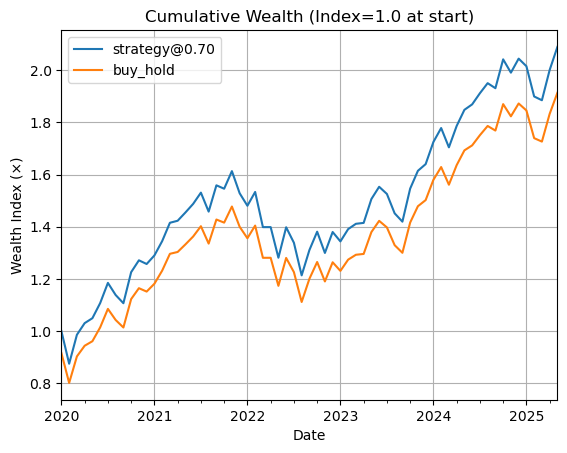

In [8]:
# %% [step7-wealth-curves]
# WHY: Plot cumulative wealth curves on the SAME TEST window for fair comparison:
#      strategy (chosen threshold) vs. target Buy&Hold vs. SPX Buy&Hold.


# USER_TODO: choose which threshold to visualize prominently
PLOT_THRESHOLD = 0.70

# Common test index
idx = Xte.index

strategy_curve = (1 + results_by_thr[PLOT_THRESHOLD]["ret"]).cumprod().reindex(idx).rename(f"strategy@{PLOT_THRESHOLD:.2f}")
bh_curve       = (1 + (yte_reg / 100.0)).cumprod().reindex(idx).rename("buy_hold")

curves = pd.concat([strategy_curve, bh_curve], axis=1)

# Add SPX (only on test window) if available
#if "spx_next_dec" in globals():
    #spx_curve = (1 + spx_next_dec.reindex(idx)).cumprod().rename("sp500_bh")
    #curves = pd.concat([curves, spx_curve], axis=1)

plt.figure()
curves.plot()
plt.title("Cumulative Wealth (Index=1.0 at start)")
plt.xlabel("Date")
plt.ylabel("Wealth Index (×)")
plt.grid(True)
plt.legend()
plt.show()


DCA comparison (amounts in EUR):
                    Buy&Hold_DCA  Signal@0.50
final_wealth            9503.250    9543.8500
total_contrib           6500.000    6500.0000
ROI_simple                 0.462       0.4683
avg_invested_share         1.000       0.8421


<Figure size 640x480 with 0 Axes>

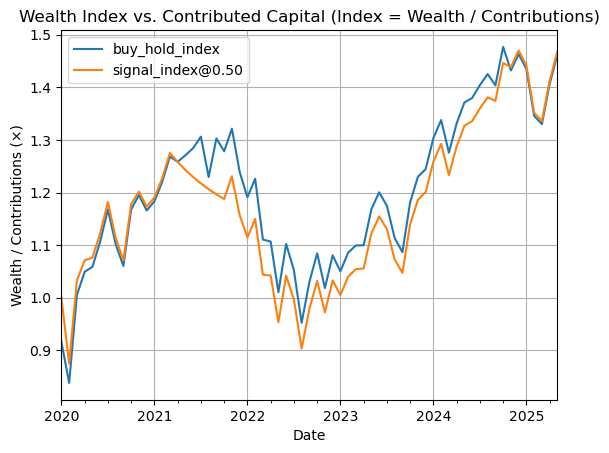

<Figure size 640x480 with 0 Axes>

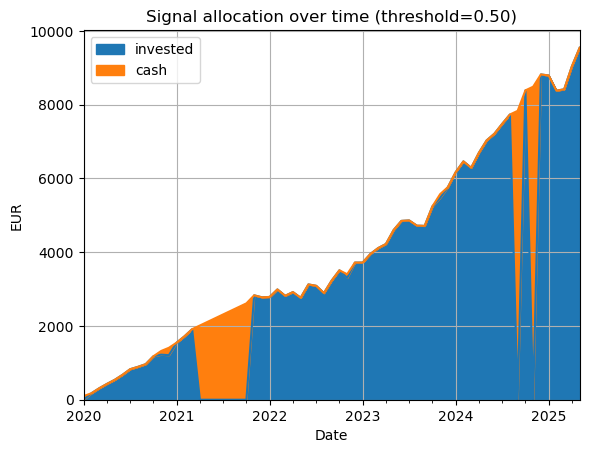

In [14]:
# notebook: 20_train_eval_linear.ipynb
# %% [step7-dca-vs-signal]  # NEW
# WHY: Compare two realistic investor behaviors with cash flows (DCA vs. signal-driven):
#   (A) Buy&Hold DCA: invest a fixed amount every month, always fully invested.
#   (B) Signal investor (long_flat): invest only on BUY months; HOLD parks cash;
#       SELL liquidates to cash. Parked cash is cumulated and deployed on the next BUY.
# Assumptions:
#   - Contributions happen at the *start* of each month, then the asset return applies.
#   - Cash earns 0% (risk-free ignored; keeps logic simple and transparent).
#   - We use test window only (out-of-sample).
from dataclasses import dataclass

# ---- User controls ----
DCA_CONTRIB_EUR: float = 100.0   # WHY: Monthly contribution for both investors.
DCA_THRESHOLD: float = 0.50      # WHY: Which probability threshold to drive BUY/HOLD/SELL.
DCA_MODE: str = TRADE_MODE       # WHY: Use the same mode as earlier ("long_flat" or "long_short").

# ---- Inputs from previous steps ----
# - test_idx: DatetimeIndex for test window
# - asset_next_dec: decimal returns of the target asset in the test window
# - results_by_thr: contains signal series per threshold (created in step6)
if DCA_THRESHOLD not in results_by_thr:
    raise KeyError(
        f"No signals for threshold={DCA_THRESHOLD:.2f}. "
        "Run step6 to populate 'results_by_thr' or adjust DCA_THRESHOLD."
    )

sig_series: pd.Series = results_by_thr[DCA_THRESHOLD]["signal"].reindex(test_idx).fillna(0).astype(int)
r_dec: pd.Series = asset_next_dec.reindex(test_idx).fillna(0.0)

# WHY: In long_flat we forbid shorting; ensure signals are {0,1}.
if DCA_MODE == "long_flat":
    sig_series = sig_series.clip(lower=0, upper=1)

@dataclass
class RunResult:
    wealth: pd.Series         # total portfolio value over time
    invested: pd.Series       # value allocated to the asset
    cash: pd.Series           # parked cash
    contrib: pd.Series        # cumulative contributions
    wealth_index: pd.Series   # wealth / cumulative_contributions (starts after first contrib)

def _simulate_dca_buy_hold(returns: pd.Series, monthly_contrib: float) -> RunResult:
    """Always invest monthly contribution immediately; stay fully invested.

    WHY:
        - This mimics a classic DCA investor who never times the market.
    """
    cash = 0.0
    invested = 0.0
    wealth, inv_hist, cash_hist, contrib_hist = [], [], [], []
    total_contrib = 0.0

    for t, r in returns.items():
        # contribution at start of month
        total_contrib += monthly_contrib
        cash += monthly_contrib

        # always invest all cash
        invested += cash
        cash = 0.0

        # apply monthly return to invested part
        invested *= (1.0 + r)

        total = invested + cash
        wealth.append(total)
        inv_hist.append(invested)
        cash_hist.append(cash)
        contrib_hist.append(total_contrib)

    wealth = pd.Series(wealth, index=returns.index, name="bh_wealth")
    invested = pd.Series(inv_hist, index=returns.index, name="bh_invested")
    cash = pd.Series(cash_hist, index=returns.index, name="bh_cash")
    contrib = pd.Series(contrib_hist, index=returns.index, name="bh_contrib")
    # WHY: Wealth index = value / contributed; undefined for 0 contrib → start after first month.
    wealth_idx = (wealth / contrib).rename("bh_wealth_index")
    return RunResult(wealth, invested, cash, contrib, wealth_idx)


def _simulate_signal_investor(
    returns: pd.Series, signals: pd.Series, monthly_contrib: float, mode: str = "long_flat"
) -> RunResult:
    """Invest only on BUY; HOLD parks cash; SELL liquidates (no short in long_flat).

    Args:
        returns: Decimal monthly returns (aligned to test months).
        signals: {+1 BUY, 0 HOLD, -1 SELL}. In 'long_flat' we treat -1 as 'go to cash'.
        monthly_contrib: Cash added at the start of each month.
        mode: 'long_flat' or 'long_short' (here we keep long_flat behavior for allocations).

    WHY:
        - Models a realistic saver who deploys more when a BUY finally arrives.
        - SELL exits to cash; we do not short unless mode == 'long_short' (not implemented for sizing here).
    """
    cash = 0.0
    invested = 0.0
    wealth, inv_hist, cash_hist, contrib_hist = [], [], [], []
    total_contrib = 0.0

    for t, r in returns.items():
        sig = int(signals.get(t, 0))

        # Add monthly savings to cash at start of month
        total_contrib += monthly_contrib
        cash += monthly_contrib

        # Decide allocation before return applies
        if sig >= 1:  # BUY
            invested += cash      # deploy ALL available cash
            cash = 0.0
        elif sig <= -1:  # SELL
            if mode == "long_flat":
                cash += invested  # liquidate to cash
                invested = 0.0
            else:
                # For 'long_short' you could allocate a short here; we keep it flat for simplicity.
                cash += invested
                invested = 0.0

        # Apply monthly return to invested part
        invested *= (1.0 + r)

        total = invested + cash
        wealth.append(total)
        inv_hist.append(invested)
        cash_hist.append(cash)
        contrib_hist.append(total_contrib)

    wealth = pd.Series(wealth, index=returns.index, name="sig_wealth")
    invested = pd.Series(inv_hist, index=returns.index, name="sig_invested")
    cash = pd.Series(cash_hist, index=returns.index, name="sig_cash")
    contrib = pd.Series(contrib_hist, index=returns.index, name="sig_contrib")
    wealth_idx = (wealth / contrib).rename("sig_wealth_index")
    return RunResult(wealth, invested, cash, contrib, wealth_idx)


# ---- Run simulations ----
bh = _simulate_dca_buy_hold(r_dec, DCA_CONTRIB_EUR)
sig = _simulate_signal_investor(r_dec, sig_series, DCA_CONTRIB_EUR, mode=DCA_MODE)

# ---- Summaries ----
def _summarize(tag: str, rr: RunResult) -> dict[str, float]:
    """Provide headline numbers for quick comparison."""
    total_contrib = float(rr.contrib.iloc[-1])
    final_wealth = float(rr.wealth.iloc[-1])
    roi = (final_wealth - total_contrib) / total_contrib if total_contrib > 0 else float("nan")  # WHY: Money-weighted simple ROI.
    invested_share = float((rr.invested / (rr.wealth.replace(0, np.nan))).mean())  # avg fraction invested
    return {
        "final_wealth": round(final_wealth, 2),
        "total_contrib": round(total_contrib, 2),
        "ROI_simple": round(roi, 4),
        "avg_invested_share": round(invested_share, 4),
    }

summary = pd.DataFrame(
    {"Buy&Hold_DCA": _summarize("BH", bh), f"Signal@{DCA_THRESHOLD:.2f}": _summarize("SIG", sig)}
)
print("DCA comparison (amounts in EUR):")
print(summary.to_string())

# ---- Plot (wealth index relative to total contributions) ----
plot_df = pd.concat(
    [bh.wealth_index.rename("buy_hold_index"), sig.wealth_index.rename(f"signal_index@{DCA_THRESHOLD:.2f}")],
    axis=1,
)

plt.figure()
plot_df.plot()
plt.title("Wealth Index vs. Contributed Capital (Index = Wealth / Contributions)")
plt.xlabel("Date")
plt.ylabel("Wealth / Contributions (×)")
plt.grid(True)
plt.legend()
plt.show()

# ---- Optional: cash vs invested visualization for signal investor ----
alloc_df = pd.concat(
    [sig.invested.rename("invested"), sig.cash.rename("cash")], axis=1
)
plt.figure()
alloc_df.plot.area()
plt.title(f"Signal allocation over time (threshold={DCA_THRESHOLD:.2f})")
plt.xlabel("Date")
plt.ylabel("EUR")
plt.grid(True)
plt.legend()
plt.show()


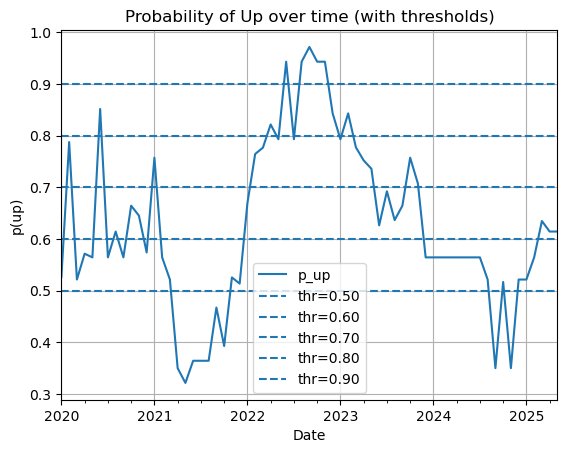

In [10]:
# %% [step8-probability-plot]
# WHY: Probability of Up over time with horizontal threshold lines.
import matplotlib.pyplot as plt

plt.figure()
proba.rename("p_up").plot()
for thr in PROB_THRESHOLDS: plt.axhline(thr, linestyle="--")
plt.title("Probability of Up over time (with thresholds)")
plt.xlabel("Date"); plt.ylabel("p(up)")
plt.grid(True); plt.legend(["p_up"] + [f"thr={t:.2f}" for t in PROB_THRESHOLDS]); plt.show()


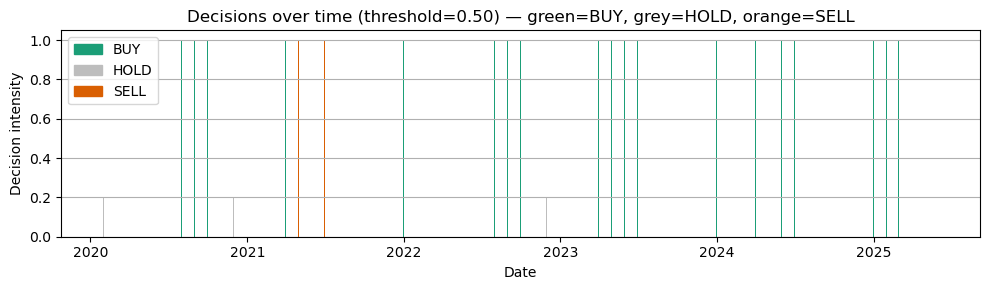

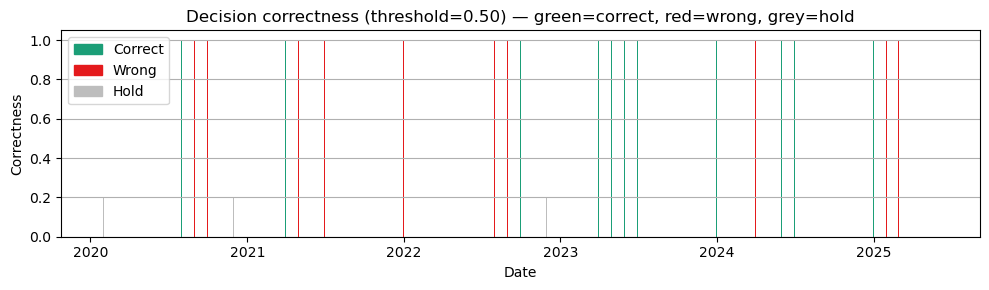

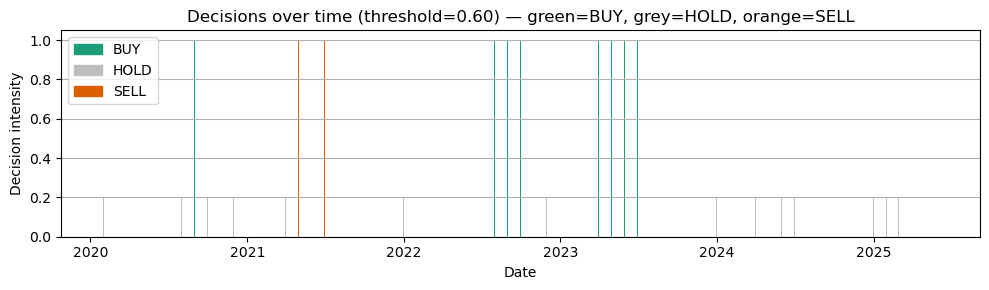

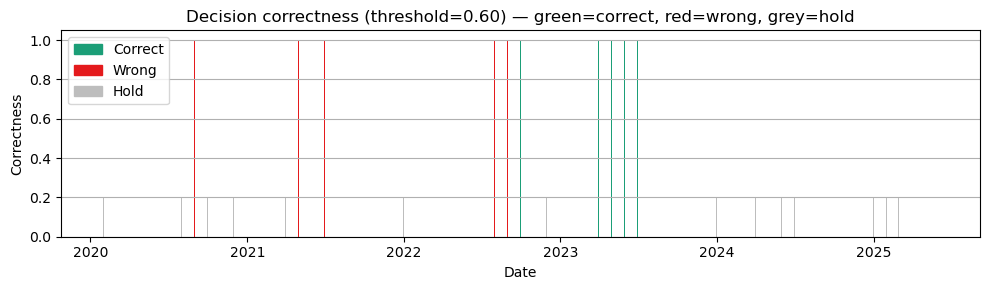

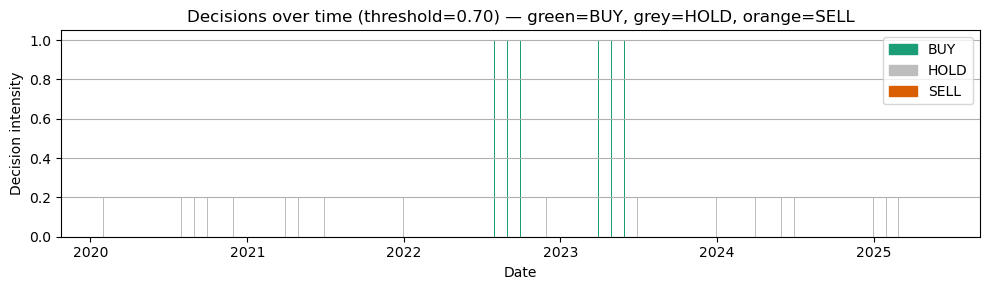

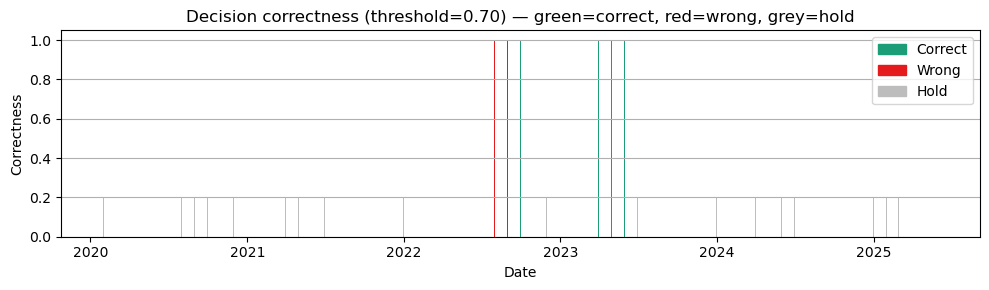

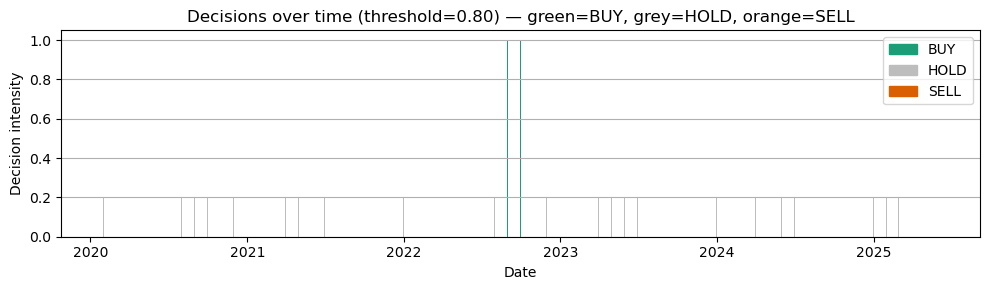

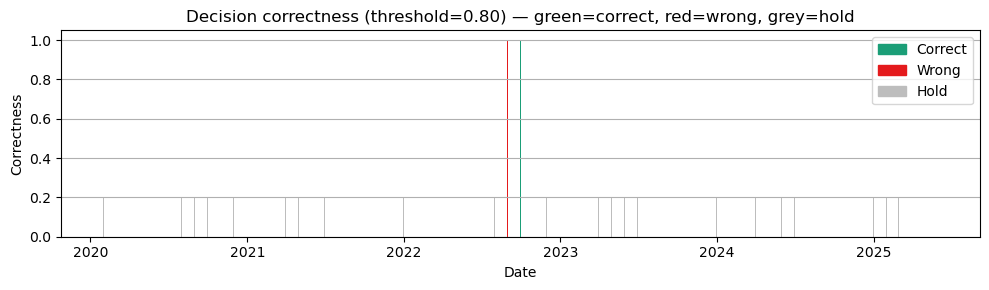

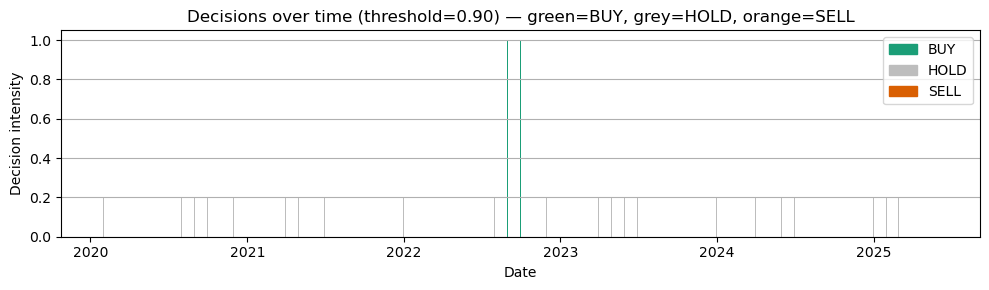

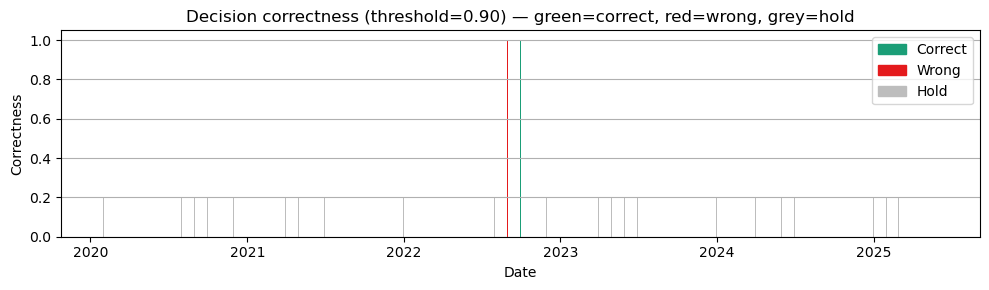

In [11]:
# %% [step9-decision-bars-colored]
# WHY: Cleaner decision & correctness visualization — colored bars per month.


# USER_TODO: welche Schwellen visualisieren?
PANEL_THRESHOLDS = [0.50, 0.60, 0.70, 0.80, 0.90]

def _correctness(sig: int, y_dec: float) -> int:
    if sig == 1: return 1 if y_dec > 0 else -1
    if sig == -1: return 1 if y_dec < 0 else -1
    return 0

for thr in PANEL_THRESHOLDS:
    sig = results_by_thr[thr]["signal"]

    # Decisions: +1 BUY, 0 HOLD, -1 SELL → Farbe
    dec_colors = sig.map({1: "#1b9e77", 0: "#bdbdbd", -1: "#d95f02"}).fillna("#bdbdbd")  # green/grey/orange
    plt.figure(figsize=(10,3))
    plt.bar(sig.index, height=np.where(sig==0, 0.2, 1.0), color=dec_colors)  # kleine Balken für HOLD
    plt.title(f"Decisions over time (threshold={thr:.2f}) — green=BUY, grey=HOLD, orange=SELL")
    plt.xlabel("Date"); plt.ylabel("Decision intensity")
    plt.grid(True, axis="y"); plt.legend(handles=[
        Patch(color="#1b9e77", label="BUY"),
        Patch(color="#bdbdbd", label="HOLD"),
        Patch(color="#d95f02", label="SELL"),
    ])
    plt.tight_layout(); plt.show()

    # Correctness: +1 korrekt, -1 falsch, 0 hold → Farbe
    y_dec = (yte_reg/100.0).reindex(sig.index)
    corr = pd.Series([_correctness(int(sig.loc[i]), float(y_dec.loc[i])) for i in sig.index], index=sig.index)
    corr_colors = corr.map({1:"#1b9e77", 0:"#bdbdbd", -1:"#e41a1c"}).fillna("#bdbdbd")  # green/grey/red
    plt.figure(figsize=(10,3))
    plt.bar(corr.index, height=np.where(corr==0, 0.2, 1.0), color=corr_colors)
    plt.title(f"Decision correctness (threshold={thr:.2f}) — green=correct, red=wrong, grey=hold")
    plt.xlabel("Date"); plt.ylabel("Correctness")
    plt.grid(True, axis="y"); plt.legend(handles=[
        Patch(color="#1b9e77", label="Correct"),
        Patch(color="#e41a1c", label="Wrong"),
        Patch(color="#bdbdbd", label="Hold"),
    ])
    plt.tight_layout(); plt.show()


In [12]:
# %% [step10-threshold-metrics-table]
# WHY: Trade-offs pro Schwelle (Trade-Rate, Precision/Recall/F1, Precision-on-Trades).

rows = []
y_true_dir = yte_clf  # 0/1
for thr in PROB_THRESHOLDS:
    sig = (proba >= thr).astype(int)   # 1=BUY, 0=HOLD
    acc_all = float(accuracy_score(y_true_dir, sig))
    prec_all = float(precision_score(y_true_dir, sig, zero_division=0))
    rec_all = float(recall_score(y_true_dir, sig, zero_division=0))
    f1_all = float(f1_score(y_true_dir, sig, zero_division=0))
    trade_rate = float(sig.mean())  # Anteil BUY-Monate
    buy_idx = sig[sig==1].index
    prec_on_trades = float((y_true_dir.loc[buy_idx].mean()) if len(buy_idx) else np.nan)

    rows.append({
        "threshold": thr,
        "trade_rate": trade_rate,
        "acc_all": acc_all,
        "precision_all": prec_all,
        "recall_all": rec_all,
        "f1_all": f1_all,
        "precision_on_trades": prec_on_trades,
    })

thr_metrics = pd.DataFrame(rows).set_index("threshold").sort_index()
print(thr_metrics.round(4).to_string())


           trade_rate  acc_all  precision_all  recall_all  f1_all  precision_on_trades
threshold                                                                             
0.5            0.8615   0.6154         0.6429      0.8780  0.7423               0.6429
0.6            0.4923   0.4615         0.5938      0.4634  0.5205               0.5938
0.7            0.3231   0.4769         0.6667      0.3415  0.4516               0.6667
0.8            0.1385   0.4462         0.7778      0.1707  0.2800               0.7778
0.9            0.0769   0.3846         0.6000      0.0732  0.1304               0.6000


In [13]:
# %% [step11-save-figures-optional]
# WHY: Optional — Figuren als PNG in artifacts/reports sichern.
REPORT_DIR = ART_DIR / "reports"
REPORT_DIR.mkdir(parents=True, exist_ok=True)
# Beispiel: letzte Figure speichern
# plt.savefig(REPORT_DIR / "last_plot.png", dpi=150)  # USER_TODO: nach jedem Plot aufrufen, falls gewünscht
print("Report dir:", REPORT_DIR)


Report dir: C:\Users\gamer\Desktop\AktienPrognose\artifacts\reports
